In [ ]:
 %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 440kB 3.3MB/s 
     |████████████████████████████████| 235kB 13.8MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 


In [ ]:
import stellargraph as sg



In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = sg.datasets.Cora()

G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices/GatherV2:0' shape=(1, None, 16) dtype=float32>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 0s - loss: 1.9614 - acc: 0.1714 - val_loss: 1.9235 - val_acc: 0.1920
Epoch 2/200
1/1 - 0s - loss: 1.9140 - acc: 0.2071 - val_loss: 1.8915 - val_acc: 0.1720
Epoch 3/200
1/1 - 0s - loss: 1.8653 - acc: 0.2357 - val_loss: 1.8438 - val_acc: 0.1940
Epoch 4/200
1/1 - 0s - loss: 1.8050 - acc: 0.2714 - val_loss: 1.7867 - val_acc: 0.2600
Epoch 5/200
1/1 - 0s - loss: 1.7304 - acc: 0.3500 - val_loss: 1.7294 - val_acc: 0.2820
Epoch 6/200
1/1 - 0s - loss: 1.6631 - acc: 0.3500 - val_loss: 1.6656 - val_acc: 0.3260
Epoch 7/200
1/1 - 0s - loss: 1.5733 - acc: 0.3714 - val_loss: 1.5941 - val_acc: 0.4140
Epoch 8/200
1/1 - 0s - loss: 1.5060 - acc: 0.4786 - val_loss: 1.5197 - val_acc: 0.5480
Epoch 9/200
1/1 - 0s - loss: 1.4088 - acc: 0.5500 - val_loss: 1.4480 - val_acc: 0.6380
Epoch 10/200
1/1 - 0s - loss: 1.3296 - acc: 0.6786 - val_loss: 1.3767 - val_acc: 0.6900
Epoch 11/200
1/1 - 0s - loss: 1.2438 - acc: 0.6929 - val_loss: 1.3027 - val_acc: 0.7020
Epoch 12/200
1/1 - 0s - loss: 1.1368 - ac

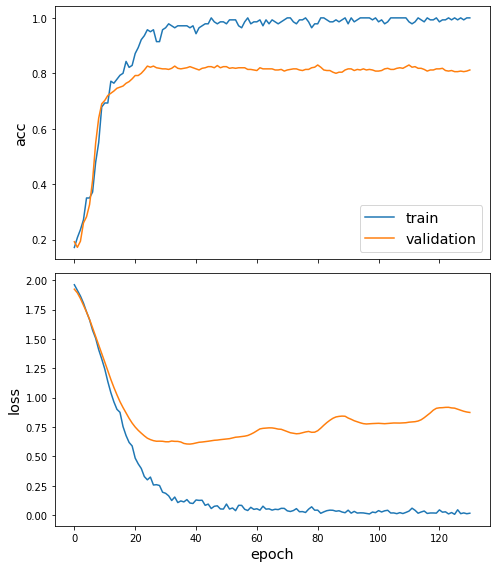

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.9128 - acc: 0.8013

Test Set Metrics:
	loss: 0.9128
	acc: 0.8013
